# Laboratorio 8 — Spark SQL DataFrames
**CC3066 – Data Science (UVG)**


## 0) Preparación del ambiente (Colab)

In [1]:

!pip -q install pyspark==3.5.1 openpyxl pandas matplotlib >/dev/null

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/Lab8"
DATA_DIR = f"{BASE_DIR}/data"
STAGING_DIR = f"{BASE_DIR}/_staging_csv"
RESULTS_DIR = f"{BASE_DIR}/resultados"

import os, warnings
warnings.filterwarnings("ignore")
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(STAGING_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("BASE_DIR:", BASE_DIR)
print("DATA_DIR:", DATA_DIR)
print("STAGING_DIR:", STAGING_DIR)
print("RESULTS_DIR:", RESULTS_DIR)



Mounted at /content/drive
BASE_DIR: /content/drive/MyDrive/Lab8
DATA_DIR: /content/drive/MyDrive/Lab8/data
STAGING_DIR: /content/drive/MyDrive/Lab8/_staging_csv
RESULTS_DIR: /content/drive/MyDrive/Lab8/resultados


## 1) Crear SparkSession

In [2]:

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("Lab8_SparkSQL_Colab")
         .master("local[*]")
         .getOrCreate())
spark


## 2) Utilidades de normalización

In [3]:

import pandas as pd, re, unicodedata
from pathlib import Path

def slugify(s: str) -> str:
    if s is None: return s
    s = unicodedata.normalize('NFKD', str(s)).encode('ascii', 'ignore').decode('ascii')
    s = re.sub(r'[^A-Za-z0-9]+', '_', s).strip('_').lower()
    return s

COLMAP = {
    "anio": ["anio","año","ano","year"],
    "mes": ["mes","month"],
    "dia": ["dia","día","day"],
    "hora": ["hora","hr","hora_del_hecho"],
    "fecha": ["fecha","fecha_hecho"],
    "dia_semana": ["dia_semana","día_semana","dia_de_la_semana"],
    "departamento": ["departamento"],
    "municipio": ["municipio"],
    "zona": ["zona"],
    "tipo_accidente": ["tipo_accidente","tipo de accidente","tipoaccidente"],
    "color": ["color"],
    "modelo": ["modelo"],
    "sexo_conductor": ["sexo_conductor","sexo del conductor","sexo"],
    "edad_conductor": ["edad_conductor","edad del conductor","edad"],
    "accidentes": ["accidentes","num_accidentes","hechos","conteo"],
    "fallecidos": ["fallecidos","num_fallecidos"],
    "lesionados": ["lesionados","num_lesionados"],
}

def normalize_columns_pdf(df_pd: pd.DataFrame) -> pd.DataFrame:
    rename = {}
    for c in list(df_pd.columns):
        sc = slugify(c)
        target = None
        for k, alts in COLMAP.items():
            if sc in [slugify(a) for a in alts]:
                target = k; break
        rename[c] = target if target else sc
    return df_pd.rename(columns=rename)


## 3) Conversión de Excel → CSV

In [4]:

def convert_all_excels_to_csv(src_dir: str, out_dir: str):
    for p in Path(out_dir).glob("**/*"):
        if p.is_file(): p.unlink()
    xlsx_files = [str(p) for p in Path(src_dir).rglob("*.xlsx") if "__MACOSX" not in str(p)]
    print(f"Detectados {len(xlsx_files)} archivos .xlsx")
    for xfile in xlsx_files:
        try:
            xls = pd.ExcelFile(xfile)
            frames = []
            for sheet in xls.sheet_names:
                df = pd.read_excel(xfile, sheet_name=sheet, dtype=str)
                if df.shape[1] <= 1: continue
                frames.append(df)
            if not frames: continue
            pdf = pd.concat(frames, ignore_index=True)
            pdf = normalize_columns_pdf(pdf)

            rel = os.path.relpath(xfile, src_dir)
            base_name = slugify(Path(rel).with_suffix("").name) + ".csv"
            parts = Path(rel).parts
            category = slugify(parts[0]) if len(parts) > 0 else "misc"
            out_cat_dir = Path(out_dir) / category
            out_cat_dir.mkdir(parents=True, exist_ok=True)
            out_csv = out_cat_dir / base_name
            pdf.to_csv(out_csv, index=False)
        except Exception as e:
            print("Error con", xfile, "->", e)

convert_all_excels_to_csv(DATA_DIR, STAGING_DIR)
print("CSV creados en:", STAGING_DIR)


Detectados 27 archivos .xlsx
CSV creados en: /content/drive/MyDrive/Lab8/_staging_csv


## 4) Carga de datos con Spark

In [5]:

from pyspark.sql import functions as F
from pathlib import Path

def load_category(cat):
    path = f"{STAGING_DIR}/{cat}/*.csv"
    if not Path(f"{STAGING_DIR}/{cat}").exists():
        return None
    return (spark.read
            .option("header", True)
            .option("inferSchema", True)
            .csv(path))

df_hechos     = load_category("hechos_de_transito")
df_vehiculos  = load_category("vehiculos_involucrados")
df_fallecidos = load_category("fallecidos")

df_hechos, df_vehiculos, df_fallecidos


(DataFrame[num_corre: string, ano_ocu: string, dia_ocu: string, hora_ocu: string, g_hora: string, g_hora_5: string, mes_ocu: string, dia_sem_ocu: string, depto_ocu: string, mupio_ocu: string, zona_ocu: string, tipo_veh: string, marca_veh: string, color_veh: string, modelo_veh: string, g_modelo_veh: string, tipo_eve: string],
 DataFrame[num_corre: string, ano_ocu: string, dia_ocu: string, hora_ocu: string, g_hora: string, g_hora_5: string, mes_ocu: string, dia_sem_ocu: string, depto_ocu: string, mupio_ocu: string, zona_ocu: string, sexo_per: string, edad_per: string, g_edad_80ymas: string, g_edad_60ymas: string, edad_quinquenales: string, estado_con: string, mayor_menor: string, tipo_veh: string, marca_veh: string, color_veh: string, modelo_veh: string, g_modelo_veh: string, tipo_eve: string],
 DataFrame[num_corre: string, ano_ocu: string, dia_ocu: string, hora_ocu: string, g_hora: string, g_hora_5: string, mes_ocu: string, dia_sem_ocu: string, depto_ocu: string, mupio_ocu: string, zona

## 5) Tipificación y normalización

In [6]:

def with_common_types(df):
    if df is None: return None
    cols = df.columns
    if "anio" in cols:
        df = df.withColumn("anio", F.regexp_extract(F.col("anio"), r"(\d{4})", 1).cast("int"))
    if "mes" in cols:
        df = df.withColumn("mes", F.regexp_extract(F.col("mes"), r"(\d+)", 0).cast("int"))
    if "dia" in cols:
        df = df.withColumn("dia", F.regexp_extract(F.col("dia"), r"(\d+)", 0).cast("int"))
    if "hora" in cols:
        df = df.withColumn("hora", F.regexp_extract(F.col("hora"), r"(\d+)", 0).cast("int"))
    for c in ["departamento","municipio","zona","tipo_accidente","color","dia_semana","sexo_conductor"]:
        if c in cols: df = df.withColumn(c, F.trim(F.lower(F.col(c))))
    return df

df_hechos     = with_common_types(df_hechos)
df_vehiculos  = with_common_types(df_vehiculos)
df_fallecidos = with_common_types(df_fallecidos)


## 6) Filtrar 2013–2023

In [7]:

YEAR_MIN, YEAR_MAX = 2013, 2023
def filter_years(df):
    return df.filter((F.col("anio")>=YEAR_MIN) & (F.col("anio")<=YEAR_MAX)) if (df and "anio" in df.columns) else df

df_hechos_f     = filter_years(df_hechos)
df_vehiculos_f  = filter_years(df_vehiculos)
df_fallecidos_f = filter_years(df_fallecidos)
[df.count() if df else None for df in [df_hechos_f, df_vehiculos_f, df_fallecidos_f]]


[64784, 97761, 91367]

## 7) EDA (20 pts)

In [8]:

def df_info(df, name):
    if df is None:
        print(f"{name}: NO DISPONIBLE"); return
    print(f"=== {name} ===")
    print("Registros:", df.count())
    df.show(5, truncate=False)
    if set(["anio","mes","departamento"]).issubset(df.columns):
        df.select("anio","mes","departamento").describe().show()

df_info(df_hechos_f, "Hechos de tránsito")
df_info(df_vehiculos_f, "Vehículos involucrados")
df_info(df_fallecidos_f, "Fallecidos")

for name, df in [("Hechos", df_hechos_f), ("Vehículos", df_vehiculos_f), ("Fallecidos", df_fallecidos_f)]:
    if df is not None and "anio" in df.columns:
        print(name, "años:", [r[0] for r in df.select("anio").distinct().orderBy("anio").collect()])

if df_hechos_f is not None and "tipo_accidente" in df_hechos_f.columns:
    print("Tipos de accidente:")
    df_hechos_f.select("tipo_accidente").distinct().orderBy("tipo_accidente").show(50, truncate=False)

for name, df in [("Hechos", df_hechos_f), ("Vehículos", df_vehiculos_f), ("Fallecidos", df_fallecidos_f)]:
    if df is not None and "departamento" in df.columns:
        print(name, "departamentos únicos:", df.select("departamento").distinct().count())


=== Hechos de tránsito ===
Registros: 64784
+---------+-------+-------+--------+-------------+--------+-------+-----------+---------+---------+--------+-----------+---------+---------+----------+------------+--------+
|num_corre|ano_ocu|dia_ocu|hora_ocu|g_hora       |g_hora_5|mes_ocu|dia_sem_ocu|depto_ocu|mupio_ocu|zona_ocu|tipo_veh   |marca_veh|color_veh|modelo_veh|g_modelo_veh|tipo_eve|
+---------+-------+-------+--------+-------------+--------+-------+-----------+---------+---------+--------+-----------+---------+---------+----------+------------+--------+
|1        |2023   |1      |15      |12:00 a 17:59|Tarde   |Enero  |Domingo    |Guatemala|Palencia |Ignorada|Pick up    |Nissan   |Negro    |2017      |2010-2019   |Colisión|
|2        |2023   |1      |15      |12:00 a 17:59|Tarde   |Enero  |Domingo    |Guatemala|Guatemala|18      |Pick up    |Nissan   |Gris     |1986      |1980-1989   |Colisión|
|3        |2023   |1      |20      |18:00 a 23:59|Noche   |Enero  |Domingo    |Guatema

In [15]:
from pyspark.sql import functions as F

# Mapa de meses ES → número
MESES = {
    "enero":1,"febrero":2,"marzo":3,"abril":4,"mayo":5,"junio":6,
    "julio":7,"agosto":8,"septiembre":9,"setiembre":9,"octubre":10,"noviembre":11,"diciembre":12
}

def normalize_from_ocu(df):
    """
    Renombra columnas del INE (ano_ocu, mes_ocu, dia_ocu, hora_ocu, dia_sem_ocu,
    depto_ocu, mupio_ocu, zona_ocu, tipo_eve, color_veh, modelo_veh, etc.)
    a los nombres estándar que usa el resto del notebook:
    anio, mes, dia, hora, dia_semana, departamento, municipio, zona, tipo_accidente, color, modelo, sexo_conductor...
    """
    if df is None:
        return None

    rename = {}
    cols = set(df.columns)

    # Temporales
    if "ano_ocu" in cols:   rename["ano_ocu"]   = "anio"
    if "dia_ocu" in cols:   rename["dia_ocu"]   = "dia"
    if "hora_ocu" in cols:  rename["hora_ocu"]  = "hora"
    if "dia_sem_ocu" in cols: rename["dia_sem_ocu"] = "dia_semana"
    if "mes_ocu" in cols:   rename["mes_ocu"]   = "mes_str"

    # Ubicación
    if "depto_ocu" in cols: rename["depto_ocu"] = "departamento"
    if "mupio_ocu" in cols: rename["mupio_ocu"] = "municipio"
    if "zona_ocu" in cols:  rename["zona_ocu"]  = "zona"

    # Categorías
    if "tipo_eve" in cols:  rename["tipo_eve"]  = "tipo_accidente"

    # Atributos de vehículo/persona (si existen)
    if "color_veh" in cols:    rename["color_veh"]    = "color"
    if "modelo_veh" in cols:   rename["modelo_veh"]   = "modelo"
    if "sexo_per" in cols:     rename["sexo_per"]     = "sexo_conductor"
    if "edad_per" in cols:     rename["edad_per"]     = "edad_conductor"

    # Renombrar
    for old, new in rename.items():
        df = df.withColumnRenamed(old, new)

    # Tipos y limpieza
    if "anio" in df.columns:
        df = df.withColumn("anio", F.regexp_extract(F.col("anio"), r"(\\d{4})", 1).cast("int"))


    if "mes_str" in df.columns and "mes" not in df.columns:
        df = df.withColumn("mes_str", F.lower(F.col("mes_str")))
        mapping = F.create_map([F.lit(x) for kv in MESES.items() for x in kv])
        df = df.withColumn("mes", mapping.getItem(F.col("mes_str")))
    if "mes" in df.columns:

        df = df.withColumn("mes", F.coalesce(F.col("mes"), F.regexp_extract(F.col("mes"), r"(\\d+)", 0).cast("int")))

    if "dia" in df.columns:
        df = df.withColumn("dia", F.regexp_extract(F.col("dia"), r"(\\d+)", 0).cast("int"))
    if "hora" in df.columns:
        df = df.withColumn("hora", F.regexp_extract(F.col("hora"), r"(\\d+)", 0).cast("int"))

    # Normalizar strings clave
    for c in ["departamento","municipio","zona","tipo_accidente","color","dia_semana","sexo_conductor"]:
        if c in df.columns:
            df = df.withColumn(c, F.trim(F.lower(F.col(c))))

    return df

# Aplica a las tres tablas
df_hechos_std     = normalize_from_ocu(df_hechos)
df_vehiculos_std  = normalize_from_ocu(df_vehiculos)
df_fallecidos_std = normalize_from_ocu(df_fallecidos)

# Imprime columnas para confirmar
print("Hechos cols:",     df_hechos_std.columns if df_hechos_std is not None else None)
print("Vehículos cols:",  df_vehiculos_std.columns if df_vehiculos_std is not None else None)
print("Fallecidos cols:", df_fallecidos_std.columns if df_fallecidos_std is not None else None)


Hechos cols: ['num_corre', 'anio', 'dia', 'hora', 'g_hora', 'g_hora_5', 'mes_str', 'dia_semana', 'departamento', 'municipio', 'zona', 'tipo_veh', 'marca_veh', 'color', 'modelo', 'g_modelo_veh', 'tipo_accidente', 'mes']
Vehículos cols: ['num_corre', 'anio', 'dia', 'hora', 'g_hora', 'g_hora_5', 'mes_str', 'dia_semana', 'departamento', 'municipio', 'zona', 'sexo_conductor', 'edad_conductor', 'g_edad_80ymas', 'g_edad_60ymas', 'edad_quinquenales', 'estado_con', 'mayor_menor', 'tipo_veh', 'marca_veh', 'color', 'modelo', 'g_modelo_veh', 'tipo_accidente', 'mes']
Fallecidos cols: ['num_corre', 'anio', 'dia', 'hora', 'g_hora', 'g_hora_5', 'mes_str', 'dia_semana', 'departamento', 'municipio', 'zona', 'sexo_conductor', 'edad_conductor', 'g_edad_80ymas', 'g_edad_60ymas', 'edad_quinquenales', 'mayor_menor', 'tipo_veh', 'marca_veh', 'color', 'modelo', 'g_modelo_veh', 'tipo_accidente', 'fall_les', 'int_o_noint', 'mes']


In [24]:
from pyspark.sql import functions as F
from pathlib import Path


def load_cat(cat):
    path = f"{STAGING_DIR}/{cat}/*.csv"
    print("Leyendo:", path)
    return (spark.read
            .option("header", True)
            .option("inferSchema", False)
            .csv(path))

df_hechos_raw     = load_cat("hechos_de_transito") if Path(f"{STAGING_DIR}/hechos_de_transito").exists() else None
df_vehiculos_raw  = load_cat("vehiculos_involucrados") if Path(f"{STAGING_DIR}/vehiculos_involucrados").exists() else None
df_fallecidos_raw = load_cat("fallecidos") if Path(f"{STAGING_DIR}/fallecidos").exists() else None

# utilidades simples y seguras
def digits_or_null(col):
    # quita todo lo que no sea [0-9]; si queda "", lo vuelve NULL
    cleaned = F.regexp_replace(F.col(col).cast("string"), r"[^0-9]", "")
    return F.when(F.length(cleaned) > 0, cleaned).otherwise(None)

MESES = {"enero":1,"febrero":2,"marzo":3,"abril":4,"mayo":5,"junio":6,
         "julio":7,"agosto":8,"septiembre":9,"setiembre":9,"octubre":10,"noviembre":11,"diciembre":12}
MESES_MAP = F.create_map([F.lit(x) for kv in MESES.items() for x in kv])

def pick(df, *names):
    # devuelve solo las columnas que sí existen en df
    return [n for n in names if n in df.columns]

def unify_explicit(df):
    if df is None: return None
    cols = df.columns

    # anio / mes / dia / hora (de *_ocu → estándar)
    year_candidates = pick(df, "anio", "ano_ocu", "year")
    month_n_candidates = pick(df, "mes", "mes_ocu", "month")
    month_t_candidates = pick(df, "mes_str")
    day_candidates = pick(df, "dia", "dia_ocu", "day")
    hour_candidates = pick(df, "hora", "hora_ocu", "hr")

    # construir columnas numéricas
    if year_candidates:
        df = df.withColumn("anio", digits_or_null(year_candidates[0]).cast("int"))
    else:
        df = df.withColumn("anio", F.lit(None).cast("int"))

    if month_n_candidates:
        df = df.withColumn("mes", digits_or_null(month_n_candidates[0]).cast("int"))
    else:
        df = df.withColumn("mes", F.lit(None).cast("int"))

    # si mes quedó null y hay mes_str textual, mapear español→número
    if "mes" in df.columns and df.select(F.max("mes")).first()[0] is None and month_t_candidates:
        df = df.withColumn("mes_txt", F.lower(F.col(month_t_candidates[0]).cast("string")))
        df = df.withColumn("mes", MESES_MAP.getItem(F.col("mes_txt")).cast("int")).drop("mes_txt")

    if day_candidates:
        df = df.withColumn("dia", digits_or_null(day_candidates[0]).cast("int"))
    else:
        df = df.withColumn("dia", F.lit(None).cast("int"))

    if hour_candidates:
        df = df.withColumn("hora", digits_or_null(hour_candidates[0]).cast("int"))
    else:
        df = df.withColumn("hora", F.lit(None).cast("int"))

    # strings clave (lower/trim) con nombres conocidos en tus CSV
    if "depto_ocu" in cols or "departamento" in cols:
        src = "depto_ocu" if "depto_ocu" in cols else "departamento"
        df = df.withColumn("departamento", F.trim(F.lower(F.col(src))))
    if "mupio_ocu" in cols or "municipio" in cols:
        src = "mupio_ocu" if "mupio_ocu" in cols else "municipio"
        df = df.withColumn("municipio", F.trim(F.lower(F.col(src))))
    if "zona_ocu" in cols or "zona" in cols:
        src = "zona_ocu" if "zona_ocu" in cols else "zona"
        df = df.withColumn("zona", F.trim(F.lower(F.col(src))))
    if "tipo_eve" in cols or "tipo_accidente" in cols:
        src = "tipo_eve" if "tipo_eve" in cols else "tipo_accidente"
        df = df.withColumn("tipo_accidente", F.trim(F.lower(F.col(src))))

    # opcionales
    if "sexo_per" in cols or "sexo_conductor" in cols:
        src = "sexo_per" if "sexo_per" in cols else "sexo_conductor"
        df = df.withColumn("sexo_conductor", F.trim(F.lower(F.col(src))))
    if "color_veh" in cols or "color" in cols:
        src = "color_veh" if "color_veh" in cols else "color"
        df = df.withColumn("color", F.trim(F.lower(F.col(src))))
    if "modelo_veh" in cols or "modelo" in cols:
        src = "modelo_veh" if "modelo_veh" in cols else "modelo"
        df = df.withColumn("modelo", F.trim(F.lower(F.col(src))))

    return df

df_hechos_std     = unify_explicit(df_hechos_raw)
df_vehiculos_std  = unify_explicit(df_vehiculos_raw)
df_fallecidos_std = unify_explicit(df_fallecidos_raw)

print("Cols Hechos:", df_hechos_std.columns if df_hechos_std else None)
print("Cols Vehículos:", df_vehiculos_std.columns if df_vehiculos_std else None)
print("Cols Fallecidos:", df_fallecidos_std.columns if df_fallecidos_std else None)

# vistazo rápido
for name, d in [("Hechos", df_hechos_std), ("Vehículos", df_vehiculos_std), ("Fallecidos", df_fallecidos_std)]:
    if d is not None:
        print(f"\n{name} — ejemplo anio/mes/dia/hora:")
        d.select("anio","mes","dia","hora").show(5, truncate=False)


Leyendo: /content/drive/MyDrive/Lab8/_staging_csv/hechos_de_transito/*.csv
Leyendo: /content/drive/MyDrive/Lab8/_staging_csv/vehiculos_involucrados/*.csv
Leyendo: /content/drive/MyDrive/Lab8/_staging_csv/fallecidos/*.csv
Cols Hechos: ['num_corre', 'ano_ocu', 'dia_ocu', 'hora_ocu', 'g_hora', 'g_hora_5', 'mes_ocu', 'dia_sem_ocu', 'depto_ocu', 'mupio_ocu', 'zona_ocu', 'tipo_veh', 'marca_veh', 'color_veh', 'modelo_veh', 'g_modelo_veh', 'tipo_eve', 'anio', 'mes', 'dia', 'hora', 'departamento', 'municipio', 'zona', 'tipo_accidente', 'color', 'modelo']
Cols Vehículos: ['num_corre', 'ano_ocu', 'dia_ocu', 'hora_ocu', 'g_hora', 'g_hora_5', 'mes_ocu', 'dia_sem_ocu', 'depto_ocu', 'mupio_ocu', 'zona_ocu', 'sexo_per', 'edad_per', 'g_edad_80ymas', 'g_edad_60ymas', 'edad_quinquenales', 'estado_con', 'mayor_menor', 'tipo_veh', 'marca_veh', 'color_veh', 'modelo_veh', 'g_modelo_veh', 'tipo_eve', 'anio', 'mes', 'dia', 'hora', 'departamento', 'municipio', 'zona', 'tipo_accidente', 'sexo_conductor', 'color'

In [25]:
from pyspark.sql import functions as F

YEAR_MIN, YEAR_MAX = 2013, 2023
def filter_years(df):
    return df.filter((F.col("anio")>=YEAR_MIN) & (F.col("anio")<=YEAR_MAX)) if (df and "anio" in df.columns) else df

def safe_count(df):
    try: return df.count()
    except: return 0

df_hechos_f     = filter_years(df_hechos_std)
df_vehiculos_f  = filter_years(df_vehiculos_std)
df_fallecidos_f = filter_years(df_fallecidos_std)

print("Hechos filtrados:", safe_count(df_hechos_f))
print("Vehículos filtrados:", safe_count(df_vehiculos_f))
print("Fallecidos filtrados:", safe_count(df_fallecidos_f))

# Distribuciones rápidas para verificar
if df_hechos_f is not None and "anio" in df_hechos_f.columns:
    print("Distribución AÑO (Hechos):")
    df_hechos_f.groupBy("anio").count().orderBy("anio").show(30, truncate=False)
if df_hechos_f is not None and "mes" in df_hechos_f.columns:
    print("Distribución MES (Hechos):")
    df_hechos_f.groupBy("mes").count().orderBy("mes").show(12, truncate=False)

# Llaves para el join
candidate_keys = ["anio","mes","dia","hora","departamento","municipio","zona","tipo_accidente"]
join_keys = [c for c in candidate_keys
             if (df_hechos_f is not None and c in df_hechos_f.columns)
             and (df_vehiculos_f is not None and c in df_vehiculos_f.columns)]
print("JOIN_KEYS candidatas:", join_keys)


Hechos filtrados: 56820
Vehículos filtrados: 76320
Fallecidos filtrados: 79699
Distribución AÑO (Hechos):
+----+-----+
|anio|count|
+----+-----+
|2015|6854 |
|2017|5879 |
|2018|6395 |
|2019|7047 |
|2020|6350 |
|2021|8153 |
|2022|7924 |
|2023|8218 |
+----+-----+

Distribución MES (Hechos):
+----+-----+
|mes |count|
+----+-----+
|NULL|16142|
|1   |4007 |
|2   |4230 |
|3   |4875 |
|4   |5213 |
|5   |2584 |
|6   |2470 |
|7   |2599 |
|8   |2663 |
|9   |2706 |
|10  |2764 |
|11  |3034 |
+----+-----+
only showing top 12 rows

JOIN_KEYS candidatas: ['anio', 'mes', 'dia', 'hora', 'departamento', 'municipio', 'zona', 'tipo_accidente']


## 8) Preguntas de análisis (80 pts)

5) Total de accidentes por año y departamento:
+----+--------------+----------------+
|anio|departamento  |total_accidentes|
+----+--------------+----------------+
|2015|alta verapaz  |315             |
|2015|baja verapaz  |112             |
|2015|chimaltenango |263             |
|2015|chiquimula    |172             |
|2015|el progreso   |160             |
|2015|escuintla     |569             |
|2015|guatemala     |2273            |
|2015|huehuetenango |173             |
|2015|izabal        |285             |
|2015|jalapa        |96              |
|2015|jutiapa       |182             |
|2015|petén         |288             |
|2015|quetzaltenango|316             |
|2015|quiché        |157             |
|2015|retalhuleu    |181             |
|2015|sacatepéquez  |209             |
|2015|san marcos    |177             |
|2015|santa rosa    |254             |
|2015|sololá        |152             |
|2015|suchitepéquez |243             |
|2015|totonicapán   |69              |
|2015|zacapa     

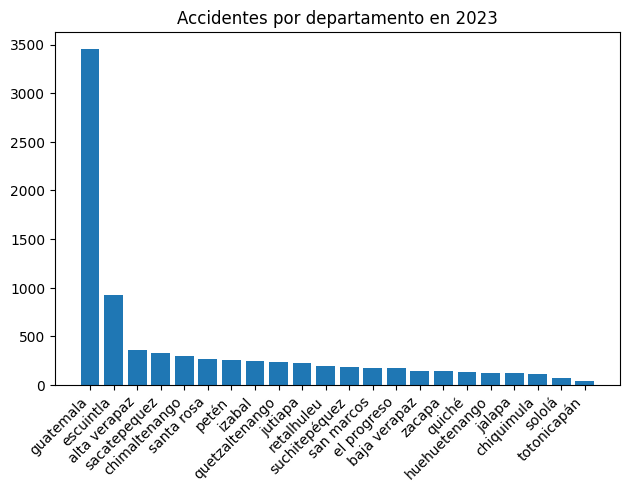

6) Día de la semana con más accidentes (2023): domingo


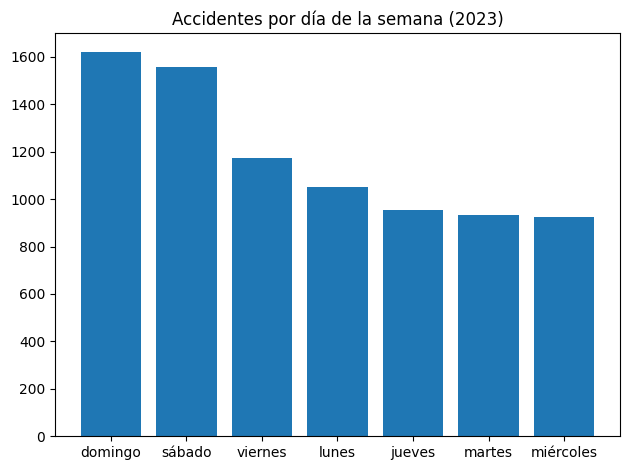

7) Distribución de accidentes por hora (mun. Guatemala):
+----+-----+
|hora|count|
+----+-----+
|NULL|6    |
|0   |177  |
|1   |165  |
|2   |123  |
|3   |95   |
|4   |86   |
|5   |87   |
|6   |94   |
|7   |108  |
|8   |104  |
|9   |134  |
|10  |147  |
|11  |109  |
|12  |101  |
|13  |100  |
|14  |122  |
|15  |125  |
|16  |121  |
|17  |166  |
|18  |172  |
|19  |203  |
|20  |221  |
|21  |226  |
|22  |205  |
+----+-----+
only showing top 24 rows



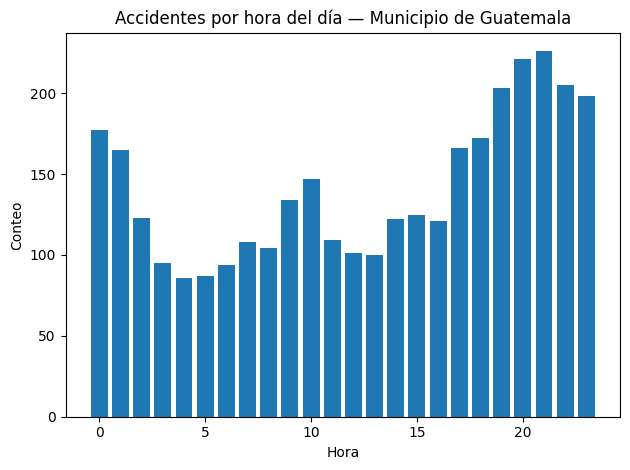

8) Registros combinados Hechos+Vehículos: 50606
9) Promedio de vehículos por accidente por departamento (top 10):
+------------+----------------------------+
|departamento|prom_vehiculos_por_accidente|
+------------+----------------------------+
|906         |2.6666666666666665          |
|1911        |2.0                         |
|1407        |2.0                         |
|1227        |2.0                         |
|712         |2.0                         |
|2209        |2.0                         |
|912         |2.0                         |
|1212        |2.0                         |
|1211        |2.0                         |
|1214        |2.0                         |
+------------+----------------------------+
only showing top 10 rows



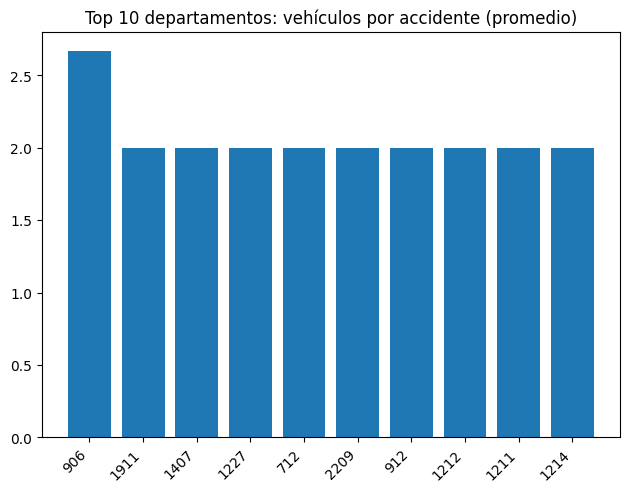

10) Top 5 colores de vehículos más involucrados:
+--------+-----+
|color   |count|
+--------+-----+
|99      |9563 |
|5       |6787 |
|ignorado|6691 |
|1       |5628 |
|2       |5475 |
+--------+-----+

11) Lesionados por atropello en 2023 por mes:
+----+-----+
|mes |count|
+----+-----+
|NULL|1710 |
+----+-----+



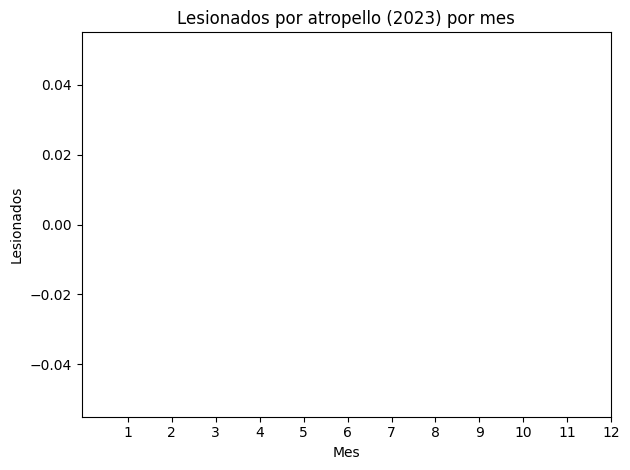

12) Fallecidos por tipo de accidente:
+--------------+----------------+
|tipo_accidente|total_fallecidos|
+--------------+----------------+
+--------------+----------------+



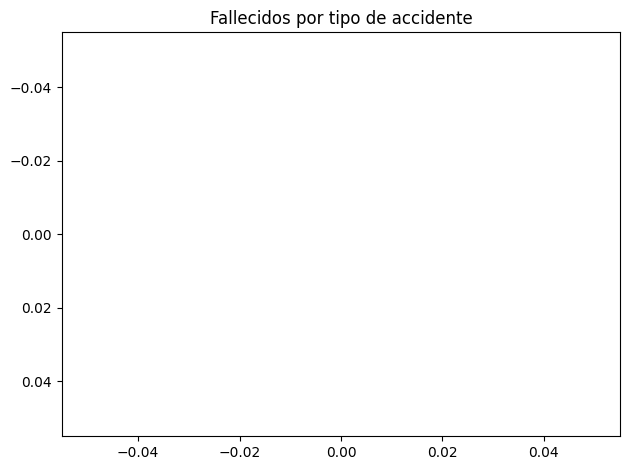

13) Accidentes por franja horaria:
+---------+-----+
|franja   |count|
+---------+-----+
|noche    |20270|
|tarde    |14677|
|mañana   |11013|
|madrugada|10860|
+---------+-----+

14) Ratio fallecidos/accidente por departamento (top 10):
+------------+----------+----------+------------------------------+
|departamento|accidentes|fallecidos|ratio_fallecidos_por_accidente|
+------------+----------+----------+------------------------------+
|1205        |1         |35        |35.0                          |
|1330        |1         |23        |23.0                          |
|1611        |2         |26        |13.0                          |
|1612        |3         |39        |13.0                          |
|512         |5         |32        |6.4                           |
|1204        |3         |18        |6.0                           |
|1329        |1         |6         |6.0                           |
|1506        |2         |11        |5.5                           |
|1608        |

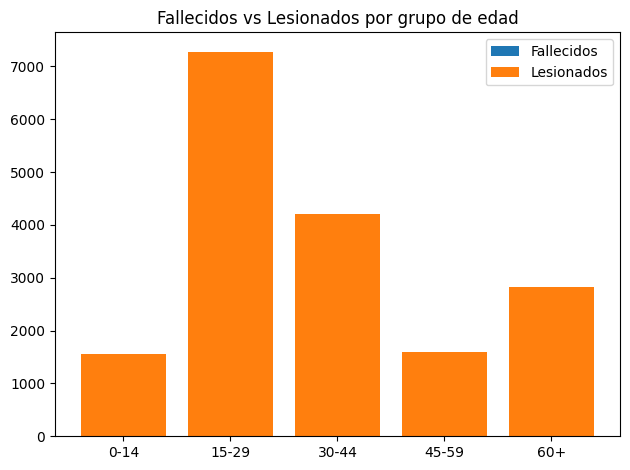

16) Municipio Guatemala — accidentes y fallecidos por zona:
+--------+----------+----------+
|zona    |accidentes|fallecidos|
+--------+----------+----------+
|1       |368       |25        |
|10      |127       |26        |
|11      |325       |70        |
|12      |451       |84        |
|13      |147       |29        |
|14      |24        |6         |
|15      |39        |9         |
|16      |48        |7         |
|17      |66        |18        |
|18      |347       |52        |
|19      |39        |4         |
|2       |76        |8         |
|21      |76        |12        |
|24      |10        |3         |
|25      |52        |19        |
|3       |92        |13        |
|4       |51        |9         |
|5       |133       |16        |
|6       |182       |20        |
|7       |472       |58        |
|8       |72        |13        |
|9       |164       |27        |
|ignorada|34        |6         |
|ignorado|0         |1         |
+--------+----------+----------+



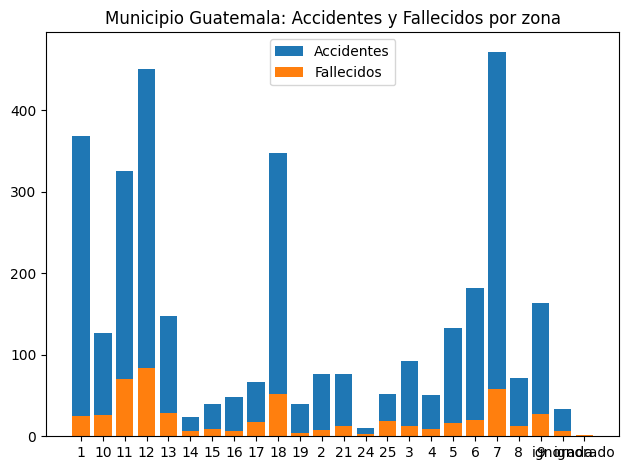

17) Porcentaje de accidentes por sexo del conductor:
+--------------+-----+----------+
|sexo_conductor|count|porcentaje|
+--------------+-----+----------+
|1             |32180|42.16     |
|hombre        |21979|28.8      |
|99            |10103|13.24     |
|9             |4947 |6.48      |
|2             |2437 |3.19      |
|mujer         |1733 |2.27      |
|ignorado      |724  |0.95      |
|18            |363  |0.48      |
|12            |331  |0.43      |
|7             |298  |0.39      |
|6             |204  |0.27      |
|11            |183  |0.24      |
|13            |114  |0.15      |
|5             |108  |0.14      |
|3             |103  |0.13      |
|10            |86   |0.11      |
|17            |80   |0.1       |
|25            |58   |0.08      |
|8             |53   |0.07      |
|16            |50   |0.07      |
+--------------+-----+----------+
only showing top 20 rows



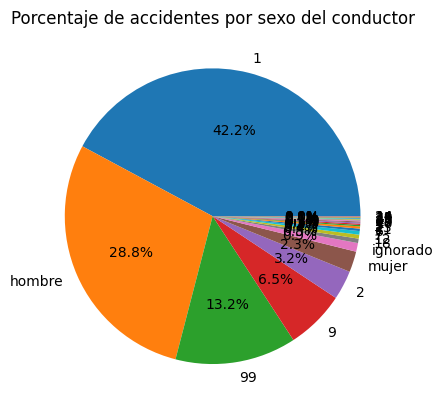


Listo: respuestas impresas y gráficas generadas. Parquet (5,9,14,17) en: /content/drive/MyDrive/Lab8/resultados


In [31]:

from pyspark.sql import functions as F
from pathlib import Path
import matplotlib.pyplot as plt

RESULTS_DIR = "/content/drive/MyDrive/Lab8/resultados"
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

def ok(df):
    try: return df is not None and df.count() > 0
    except: return False

# ----------------------------------------------------------------
# 5) Total de accidentes por año y departamento + gráfico de barras
# ----------------------------------------------------------------
i5_path = f"{RESULTS_DIR}/accidentes_por_ano_depto.parquet"
if Path(i5_path).exists():
    i5 = spark.read.parquet(i5_path)
else:
    i5 = (df_hechos_f.groupBy("anio","departamento")
          .count().withColumnRenamed("count","total_accidentes"))
    i5.write.mode("overwrite").parquet(i5_path)

print("5) Total de accidentes por año y departamento:")
i5.orderBy("anio","departamento").show(30, truncate=False)

# gráfica (barra) — elegimos el último año disponible
anio_max = i5.agg(F.max("anio")).first()[0]
pdf5 = i5.filter(F.col("anio")==anio_max).orderBy(F.col("total_accidentes").desc()).toPandas()
plt.figure()
plt.bar(pdf5["departamento"], pdf5["total_accidentes"])
plt.xticks(rotation=45, ha="right"); plt.tight_layout()
plt.title(f"Accidentes por departamento en {anio_max}")
plt.show()

# ----------------------------------------------------------------
# 6) Día de semana con más accidentes en 2023 + gráfico columnas
# ----------------------------------------------------------------
i6 = (df_hechos_f.filter(F.col("anio")==2023)
      .groupBy("dia_semana").count()
      .orderBy(F.col("count").desc()))
top_day = i6.first()["dia_semana"] if i6.count()>0 else None
print(f"6) Día de la semana con más accidentes (2023): {top_day}")
pdf6 = i6.toPandas()
plt.figure()
plt.bar(pdf6["dia_semana"], pdf6["count"])
plt.title("Accidentes por día de la semana (2023)")
plt.tight_layout(); plt.show()

# ----------------------------------------------------------------
# 7) Distribución por hora del día (municipio Guatemala) + histograma
# ----------------------------------------------------------------
i7 = (df_hechos_f.filter(F.col("municipio")=="guatemala")
      .groupBy("hora").count().orderBy("hora"))
print("7) Distribución de accidentes por hora (mun. Guatemala):")
i7.show(24, truncate=False)
pdf7 = i7.toPandas()
plt.figure()
plt.bar(pdf7["hora"], pdf7["count"])
plt.title("Accidentes por hora del día — Municipio de Guatemala")
plt.xlabel("Hora"); plt.ylabel("Conteo"); plt.tight_layout(); plt.show()

# ----------------------------------------------------------------
# 8) Unión Hechos + Vehículos (llave compuesta) y #registros combinados
# ----------------------------------------------------------------
candidates = [c for c in ["anio","mes","dia","hora","departamento","municipio","zona","tipo_accidente"]
              if (c in df_hechos_f.columns and c in df_vehiculos_f.columns)]
df_hv = df_hechos_f.join(df_vehiculos_f, on=candidates, how="inner")
cnt_hv = df_hv.count()
if cnt_hv == 0:
    minimal = [c for c in ["anio","mes","departamento","municipio","tipo_accidente"] if c in candidates]
    if len(minimal)>=2:
        df_hv = df_hechos_f.join(df_vehiculos_f, on=minimal, how="inner")
        cnt_hv = df_hv.count()
print(f"8) Registros combinados Hechos+Vehículos: {cnt_hv}")

# ----------------------------------------------------------------
# 9) Promedio de vehículos por accidente por departamento + guardar y graficar top10
# ----------------------------------------------------------------
i9_path = f"{RESULTS_DIR}/prom_vehiculos_por_accidente.parquet"
if Path(i9_path).exists():
    i9 = spark.read.parquet(i9_path)
else:
    veh_por_hecho = df_hv.groupBy(candidates).agg(F.count(F.lit(1)).alias("vehiculos_en_hecho"))
    i9 = (veh_por_hecho.groupBy("departamento")
          .agg(F.avg("vehiculos_en_hecho").alias("prom_vehiculos_por_accidente"))
          .orderBy(F.col("prom_vehiculos_por_accidente").desc()))
    i9.write.mode("overwrite").parquet(i9_path)

print("9) Promedio de vehículos por accidente por departamento (top 10):")
i9.orderBy(F.col("prom_vehiculos_por_accidente").desc()).show(10, truncate=False)

pdf9 = i9.orderBy(F.col("prom_vehiculos_por_accidente").desc()).limit(10).toPandas()
plt.figure()
plt.bar(pdf9["departamento"], pdf9["prom_vehiculos_por_accidente"])
plt.xticks(rotation=45, ha="right"); plt.tight_layout()
plt.title("Top 10 departamentos: vehículos por accidente (promedio)")
plt.show()

# ----------------------------------------------------------------
# 10) Top 5 colores de vehículos
# ----------------------------------------------------------------
i10 = (df_vehiculos_f.groupBy("color").count()
       .orderBy(F.col("count").desc()).limit(5))
print("10) Top 5 colores de vehículos más involucrados:")
i10.show(truncate=False)

# ----------------------------------------------------------------
# 11) Lesionados por atropello en 2023 por mes + línea
#     (usamos df_fallecidos_f: fall_les == 'lesionado' y tipo_accidente contiene 'atrop')
# ----------------------------------------------------------------
i11 = (df_fallecidos_f
       .filter((F.col("anio")==2023) &
               (F.lower(F.col("fall_les")).like("%lesion%")) &
               (F.col("tipo_accidente").like("%atrop%")))
       .groupBy("mes").count().orderBy("mes"))
print("11) Lesionados por atropello en 2023 por mes:")
i11.show(12, truncate=False)

pdf11 = i11.toPandas()
plt.figure()
plt.plot(pdf11["mes"], pdf11["count"])
plt.title("Lesionados por atropello (2023) por mes")
plt.xlabel("Mes"); plt.ylabel("Lesionados"); plt.xticks(range(1,13))
plt.tight_layout(); plt.show()

# ----------------------------------------------------------------
# 12) Relacionar Hechos+Fallecidos (misma llave del 8) → total de fallecidos por tipo de accidente (barras horizontales)
# ----------------------------------------------------------------
join_f = [c for c in candidates if c in df_fallecidos_f.columns]
df_hf = df_hechos_f.join(df_fallecidos_f, on=join_f, how="inner")
i12 = (df_hf.filter(F.lower(F.col("fall_les")).like("%fallec%"))
       .groupBy("tipo_accidente")
       .agg(F.count(F.lit(1)).alias("total_fallecidos"))
       .orderBy(F.col("total_fallecidos").desc()))
print("12) Fallecidos por tipo de accidente:")
i12.show(truncate=False)

pdf12 = i12.toPandas()
plt.figure()
plt.barh(pdf12["tipo_accidente"], pdf12["total_fallecidos"])
plt.title("Fallecidos por tipo de accidente")
plt.tight_layout(); plt.gca().invert_yaxis(); plt.show()

# ----------------------------------------------------------------
# 13) Franjas horarias y conteo
# ----------------------------------------------------------------
i13 = (df_hechos_f.withColumn(
        "franja",
        F.when((F.col("hora")>=6) & (F.col("hora")<12), "mañana")
         .when((F.col("hora")>=12)&(F.col("hora")<18), "tarde")
         .when((F.col("hora")>=18)&(F.col("hora")<24), "noche")
         .otherwise("madrugada"))
      .groupBy("franja").count()
      .orderBy(F.col("count").desc()))
print("13) Accidentes por franja horaria:")
i13.show(truncate=False)

# ----------------------------------------------------------------
# 14) Ratio fallecidos/accidentes por departamento + guardar
# ----------------------------------------------------------------
i14_path = f"{RESULTS_DIR}/ratio_fallecidos_por_accidente.parquet"
if Path(i14_path).exists():
    i14 = spark.read.parquet(i14_path)
else:
    acc = df_hechos_f.groupBy("departamento").count().withColumnRenamed("count","accidentes")
    fall = (df_fallecidos_f.filter(F.lower(F.col("fall_les")).like("%fallec%"))
            .groupBy("departamento").count().withColumnRenamed("count","fallecidos"))
    i14 = (acc.join(fall, on="departamento", how="left")
           .fillna({"fallecidos":0})
           .withColumn("ratio_fallecidos_por_accidente", F.col("fallecidos")/F.col("accidentes"))
           .orderBy(F.col("ratio_fallecidos_por_accidente").desc()))
    i14.write.mode("overwrite").parquet(i14_path)

print("14) Ratio fallecidos/accidente por departamento (top 10):")
i14.show(10, truncate=False)

# ----------------------------------------------------------------
# 15) Grupos de edad más afectados (fallecidos vs lesionados) + barras comparativas
#     (usamos df_fallecidos_f, que trae 'fall_les')
# ----------------------------------------------------------------
def age_bucket(col):
    return (F.when(F.col(col) < 15, "0-14")
             .when((F.col(col) >=15) & (F.col(col)<30), "15-29")
             .when((F.col(col) >=30) & (F.col(col)<45), "30-44")
             .when((F.col(col) >=45) & (F.col(col)<60), "45-59")
             .otherwise("60+"))

# extraer dígito de la edad y clasificar
ff = (df_fallecidos_f
      .withColumn("edad_num", F.regexp_extract(F.col("edad_conductor").cast("string"), r"(\d+)", 1).cast("int")))

fal = (ff.filter(F.lower(F.col("fall_les")).like("%fallec%"))
       .withColumn("grupo_edad", age_bucket("edad_num"))
       .groupBy("grupo_edad").count().withColumnRenamed("count","fallecidos"))

les = (ff.filter(F.lower(F.col("fall_les")).like("%lesion%"))
       .withColumn("grupo_edad", age_bucket("edad_num"))
       .groupBy("grupo_edad").count().withColumnRenamed("count","lesionados"))

i15 = fal.join(les, on="grupo_edad", how="outer").fillna(0).orderBy("grupo_edad")
print("15) Grupos de edad más afectados (fallecidos vs lesionados):")
i15.show(truncate=False)

pdf15 = i15.toPandas()
plt.figure()
plt.bar(pdf15["grupo_edad"], pdf15["fallecidos"])
plt.bar(pdf15["grupo_edad"], pdf15["lesionados"], bottom=0)
plt.legend(["Fallecidos","Lesionados"])
plt.title("Fallecidos vs Lesionados por grupo de edad")
plt.tight_layout(); plt.show()

# ----------------------------------------------------------------
# 16) Municipio Guatemala: accidentes por zona + fallecidos por zona (barras ambas)
# ----------------------------------------------------------------
acc_z = (df_hechos_f.filter(F.col("municipio")=="guatemala")
         .groupBy("zona").count().withColumnRenamed("count","accidentes"))
fall_z = (df_fallecidos_f.filter(F.col("municipio")=="guatemala")
          .filter(F.lower(F.col("fall_les")).like("%fallec%"))
          .groupBy("zona").count().withColumnRenamed("count","fallecidos"))
i16 = acc_z.join(fall_z, on="zona", how="outer").fillna(0).orderBy("zona")
print("16) Municipio Guatemala — accidentes y fallecidos por zona:")
i16.show(30, truncate=False)

pdf16 = i16.toPandas()
plt.figure()
plt.bar(pdf16["zona"], pdf16["accidentes"])
plt.bar(pdf16["zona"], pdf16["fallecidos"], bottom=0)
plt.legend(["Accidentes","Fallecidos"])
plt.title("Municipio Guatemala: Accidentes y Fallecidos por zona")
plt.tight_layout(); plt.show()

# ----------------------------------------------------------------
# 17) % accidentes H vs M (tabla vehículos) + guardar + pie
# ----------------------------------------------------------------
total = df_vehiculos_f.count()
i17 = (df_vehiculos_f.groupBy("sexo_conductor").count()
       .withColumn("porcentaje", F.round(F.col("count")/F.lit(total)*100, 2))
       .orderBy(F.col("porcentaje").desc()))
print("17) Porcentaje de accidentes por sexo del conductor:")
i17.show(truncate=False)
i17_path = f"{RESULTS_DIR}/porcentaje_accidentes_por_sexo.parquet"
i17.write.mode("overwrite").parquet(i17_path)

pdf17 = i17.toPandas()
plt.figure()
plt.pie(pdf17["porcentaje"], labels=pdf17["sexo_conductor"], autopct="%1.1f%%")
plt.title("Porcentaje de accidentes por sexo del conductor")
plt.show()

print("\nListo: respuestas impresas y gráficas generadas. Parquet (5,9,14,17) en:", RESULTS_DIR)
